# **Data Cleaning Notebook**

## Objectives

* Evaluate missing data
* Clean data

## Inputs

* outputs/datasets/collection/house_prices.csv

## Outputs

* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned

## Conclusions

* Data Cleaning Pipeline


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/data-analytics-housing-project/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/data-analytics-housing-project'

## Load Collected data

In [4]:
import pandas as pd
df_raw_path = "outputs/datasets/collection/house_prices.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


## Data Exploration

In Data Cleaning you are interested to check the distribution and shape of a variable with missing data.

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [6]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation and PPS Analysis

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate Correlations and Power Predictive Score

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/codeany/.local

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.103  0.0  0.0  0.0  0.065  0.702


Display as Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



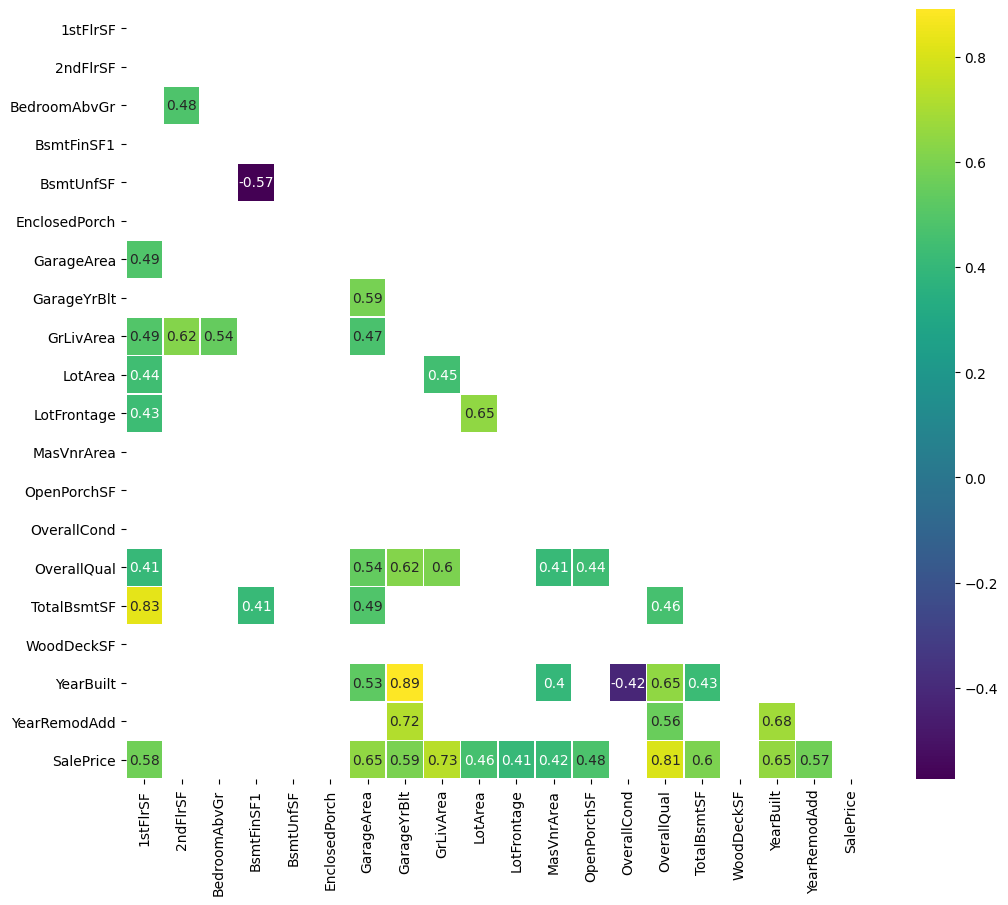



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



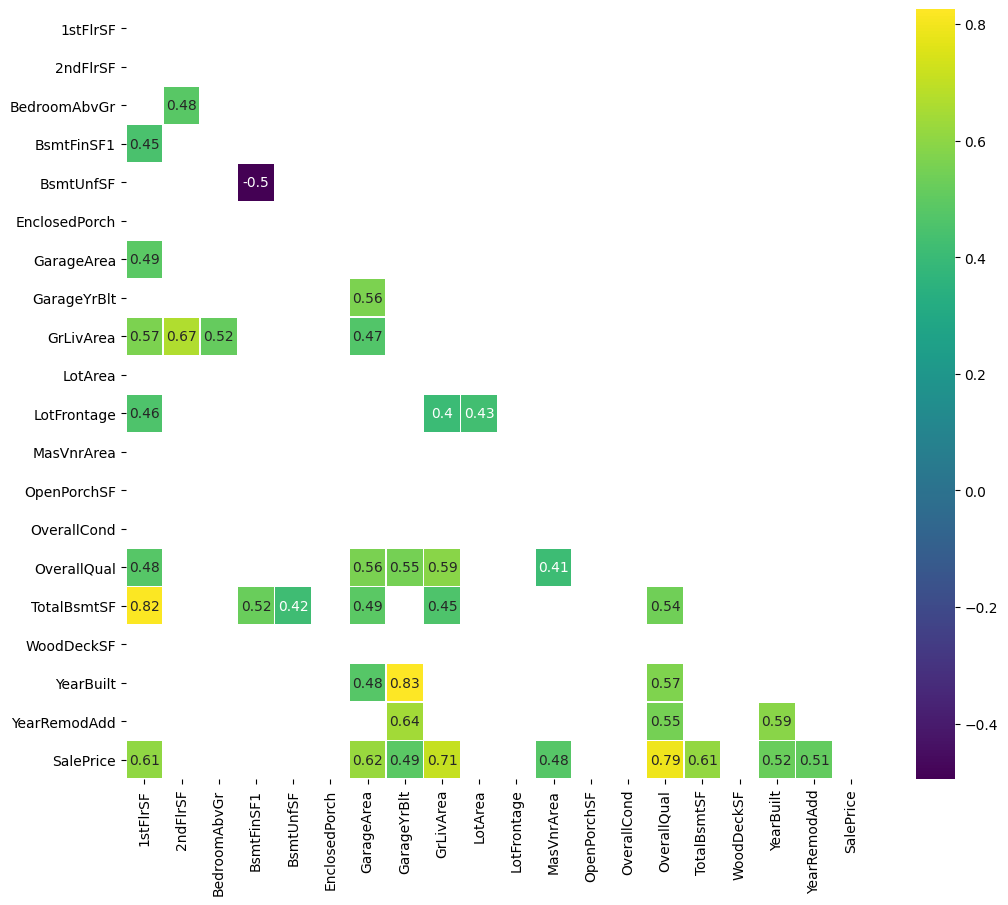



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



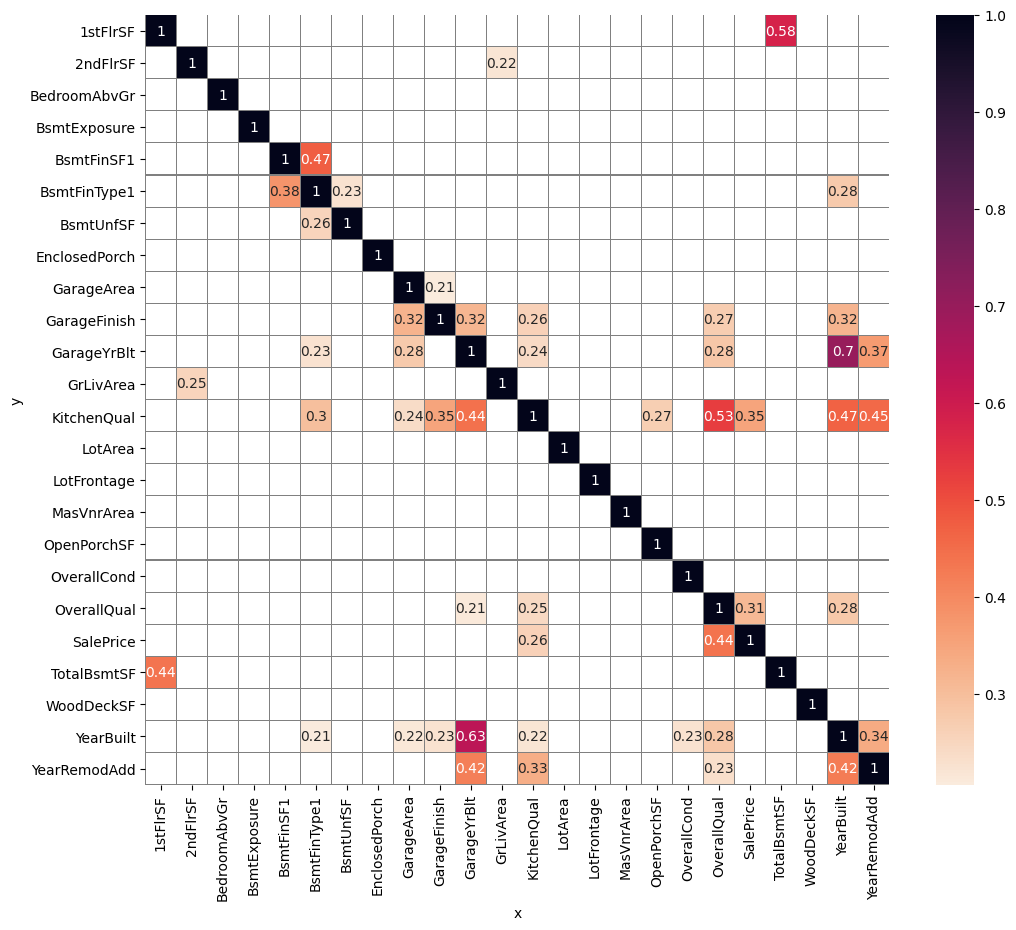

In [9]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

## Data Cleaning

### Assessing Missing Data Levels

Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [10]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

Check missing data levels for the collected dataset.

In [11]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


### Data Cleaning Spreadsheet Summary

Consider your spreadsheet notes on potential approaches to handle missing 

<img src="../static/images/data-cleaning-sheet.png" alt="abbreviations for housing data" height="500" />

### Dealing with Missing Data

GarageYrBlt may have missing data because the garage was built when the house was built.

This would mean the rows corresponding GarageArea would have a greater value than 0.

On the other hand, if missing data means no garage - then GarageArea would be zero for rows with missing GarageYrBlt data.

In [12]:
def check_garage_data(df):
    # We filter to show rows where GarageYrBlt is missing
    missing_garage_yr_blt = df[df['GarageYrBlt'].isnull()]
    # Then check which of these rows have a GarageArea of 0
    zero_garage_area = missing_garage_yr_blt[missing_garage_yr_blt['GarageArea'] == 0]
    # Calculate the percentage
    percentage_with_zero_garage_area = (len(zero_garage_area) / len(missing_garage_yr_blt)) * 100 if len(missing_garage_yr_blt) > 0 else 0
    return percentage_with_zero_garage_area

percentage = check_garage_data(df)
print(f"GarageYrBlt with 0 GarageArea: {percentage}%")


GarageYrBlt with 0 GarageArea: 100.0%


The result of 100% means that if a property has a missing value for GarageYrBlt, then it does not have a garage. 

This will be useful when we add the the column 'GarageArea_binary'.

For now, we are replacing NaN values with 0 for the GarageYrBlt column.

In [13]:
df['GarageYrBlt'].fillna(0, inplace=True)

We check to see if GarageYrBlt has been successfully cleaned by calling our EvaluateMissingData function again.

In [14]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
MasVnrArea,8,0.55,float64


We notice 'GarageYrBlt' has been removed from the missing data list.

The remaining variables will not be used in our Model and no further imputation is required.

In [15]:
df.head(20)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,0.0,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000
5,796,566.0,1.0,No,732,GLQ,64,NaN,480,Unf,...,85.0,0.0,30,5,5,796,NaN,1993,1995,143000
6,1694,0.0,3.0,Av,1369,GLQ,317,NaN,636,RFn,...,75.0,186.0,57,5,8,1686,NaN,2004,2005,307000
7,1107,983.0,3.0,Mn,859,ALQ,216,NaN,484,NaN,...,NaN,240.0,204,6,7,1107,NaN,1973,1973,200000
8,1022,752.0,2.0,No,0,Unf,952,NaN,468,Unf,...,51.0,0.0,0,5,7,952,NaN,1931,1950,129900
9,1077,0.0,2.0,No,851,GLQ,140,NaN,205,RFn,...,50.0,0.0,4,6,5,991,NaN,1939,1950,118000


### Add Columns

It way be significant if our properties do or do not have certain features. 

We will examine if our properties have a 2nd floor, Garage, Basement, an Open Porch and compare the binary values of 'yes' or 'no' to Sales Price. If they appear significant, we will add these variables to our cleaned data.

In [16]:
def add_binary_columns(df, columns):
    for col in columns:
        df[f'{col}_binary'] = df[col].apply(lambda x: 1 if x > 0 else 0)
    return df

columns_to_convert = ['2ndFlrSF', 'TotalBsmtSF', 'GarageArea', 'OpenPorchSF']

df = add_binary_columns(df, columns_to_convert)

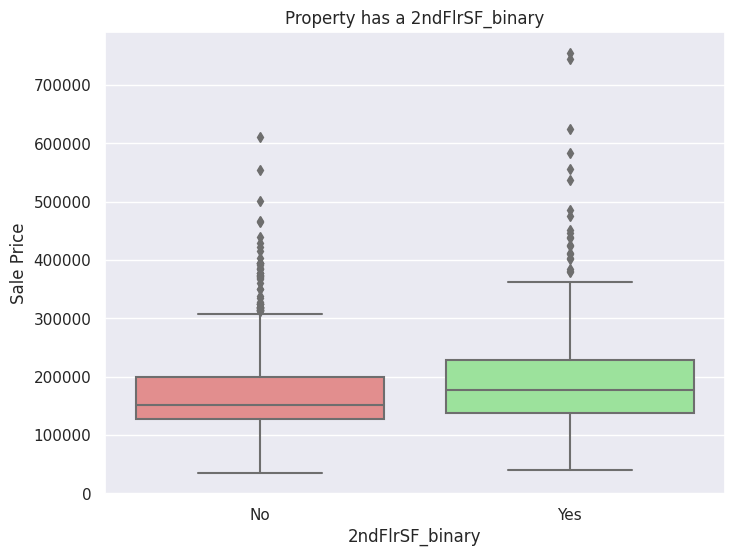

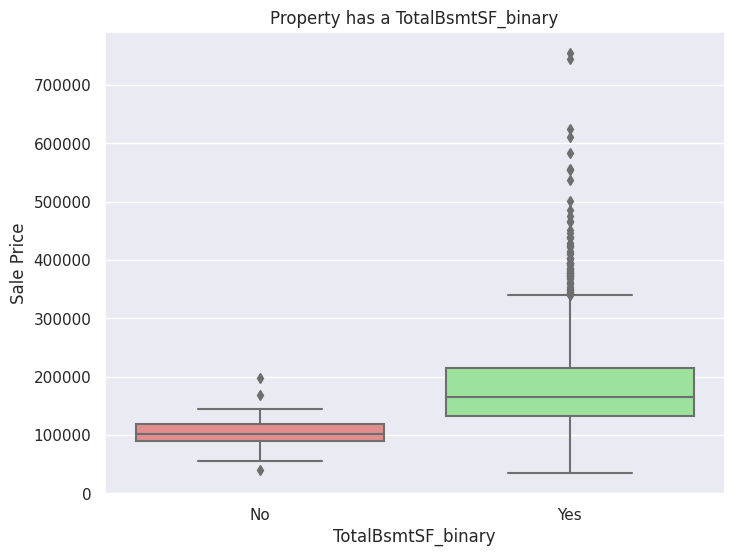

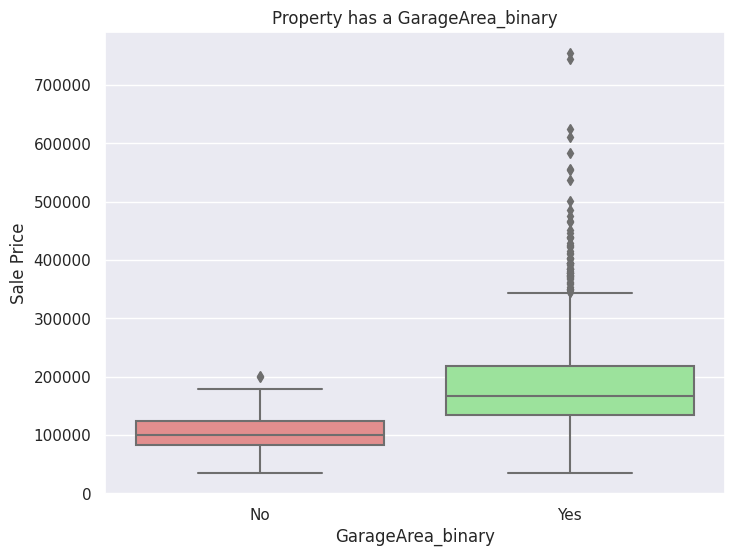

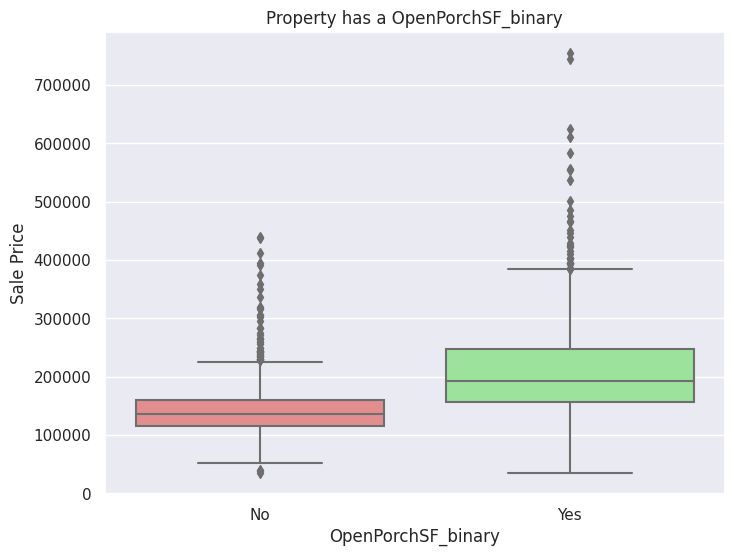

In [17]:
sns.set_theme(style="darkgrid")

palette = {0: "lightcoral", 1: "lightgreen"}

binary_columns = [f'{col}_binary' for col in columns_to_convert]

for col in binary_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=col, y='SalePrice', data=df, palette=palette)
    plt.title(f'Property has a {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Sale Price')
    plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
    plt.show()



Having a Garage, Basment or Open porch does appear to have a positive impact on the Sales Price.

Having a 2nd floor does not appear to influence Sale Price. 

The number of floor levels your property has does not seem significant in this market - As identified in the previous notebook, total Living area is significant.

We will drop 2ndFlrSF_binary and 2ndFlrSF (60% of properties do not have a 2nd floor) from our dataframe.

We are also dropping variables that did not show high correlation to Sale Price The remaining columns can be seen in the output below:

In [18]:
df = df.drop(columns=['BsmtExposure', 'BedroomAbvGr', '2ndFlrSF', 'KitchenQual', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtUnfSF', 'OverallCond', 'GarageFinish', 'LotFrontage', 'MasVnrArea', 'EnclosedPorch', 'OpenPorchSF', 'WoodDeckSF', 'YearRemodAdd', '2ndFlrSF_binary'])
df.head(10)


,1stFlrSF,GarageArea,GarageYrBlt,GrLivArea,LotArea,OverallQual,TotalBsmtSF,YearBuilt,SalePrice,TotalBsmtSF_binary,GarageArea_binary,OpenPorchSF_binary
0,856,548,2003.0,1710,8450,7,856,2003,208500,1,1,1
1,1262,460,1976.0,1262,9600,6,1262,1976,181500,1,1,0
2,920,608,2001.0,1786,11250,7,920,2001,223500,1,1,1
3,961,642,1998.0,1717,9550,7,756,1915,140000,1,1,1
4,1145,836,2000.0,2198,14260,8,1145,2000,250000,1,1,1
5,796,480,1993.0,1362,14115,5,796,1993,143000,1,1,1
6,1694,636,2004.0,1694,10084,8,1686,2004,307000,1,1,1
7,1107,484,1973.0,2090,10382,7,1107,1973,200000,1,1,1
8,1022,468,1931.0,1774,6120,7,952,1931,129900,1,1,0
9,1077,205,1939.0,1077,7420,5,991,1939,118000,1,1,1


GarageYrBlt is unneccessarily in Float type to we will convert it to an integer as years are whole numbers:

In [20]:
df['GarageYrBlt'] = df['GarageYrBlt'].astype(int)


In [21]:
df.head(5)

,1stFlrSF,GarageArea,GarageYrBlt,GrLivArea,LotArea,OverallQual,TotalBsmtSF,YearBuilt,SalePrice,TotalBsmtSF_binary,GarageArea_binary,OpenPorchSF_binary
0,856,548,2003,1710,8450,7,856,2003,208500,1,1,1
1,1262,460,1976,1262,9600,6,1262,1976,181500,1,1,0
2,920,608,2001,1786,11250,7,920,2001,223500,1,1,1
3,961,642,1998,1717,9550,7,756,1915,140000,1,1,1
4,1145,836,2000,2198,14260,8,1145,2000,250000,1,1,1


## Split Train and Test Set

* It is critical to split the cleaned dataset in 2 parts, so we will be able to train the ML model with training data and then test it on reserved and unseen test data.

In [22]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 12) 
TestSet shape: (292, 12)


A final check before pushing the cleaned data to the repository and there is no missing data in the TrainSet:

In [23]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


# Push Cleaned Data to Repo

In [ ]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/collection folder
except Exception as e:
  print(e)

### Train Set

In [ ]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

### Test Set

In [ ]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)